# Naive Logistic Regression

## Import Libraries - Import data

In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [3]:
#Importing data
data = pd.read_excel('C:/Users/diama/Desktop/Dissertation/default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

## Preliminary EDA for numerical features - Check for missing values

In [5]:
#no missing values
data.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [6]:
#initial preprocessing: drop 'ID' column, rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency 
data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [7]:
#checking the imbalance of the dataset
data.DEFAULT.value_counts()

0    23364
1     6636
Name: DEFAULT, dtype: int64

In [8]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [9]:
#replace 0's with 3's as there is not a 0 category for marriage on data description, thus I assign 0 to 3 (other) 
data['MARRIAGE'].replace(0,3,inplace=True)
data.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [10]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [12]:
#Info about data types

#LIMIT_BAL: numerical                    
#SEX: binary                        
#EDUCATION: categorical             
#MARRIAGE: categorical                     
#AGE: numerical                         
#PAY_1: categorical 
#PAY_2: categorical                       
#PAY_3: categorical                        
#PAY_4: categorical                        
#PAY_5: categorical                                                    
#PAY_6: categorical                         
#BILL_AMT1: numerical                     
#BILL_AMT2: numerical                    
#BILL_AMT3: numerical                     
#BILL_AMT4: numerical                     
#BILL_AMT5: numerical                     
#BILL_AMT6: numerical                     
#PAY_AMT1:  numerical                     
#PAY_AMT2:  numerical                    
#PAY_AMT3:  numerical                     
#PAY_AMT4:  numerical                     
#PAY_AMT5:  numerical                    
#PAY_AMT6:  numerical                     
#DEFAULT:   binary    

In [13]:
#functions for ploting boxplots and histograms of numerical columns
def plot_boxplots(dataframe):
    num_columns = len(dataframe.columns)
    num_rows = (num_columns + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

    for i, column in enumerate(dataframe.columns):
        row = i // 2
        col = i % 2
        axes[row, col].boxplot(dataframe[column])
        axes[row, col].set_title(f'Boxplot of {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Values')
        axes[row, col].grid(True, linestyle='--', alpha=0.7)


    plt.tight_layout()
    plt.show()
    

def plot_histograms(dataframe):
    num_columns = len(dataframe.columns)
    num_rows = (num_columns + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

    for i, column in enumerate(dataframe.columns):
        row = i // 2
        col = i % 2
        axes[row, col].hist(dataframe[column])
        axes[row, col].set_title(f'Histogram of {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Frequency')

    # Remove any unused subplots
    if num_columns % 2 != 0:
        fig.delaxes(axes[num_rows-1, 1])

    plt.tight_layout()
    plt.show()

In [14]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

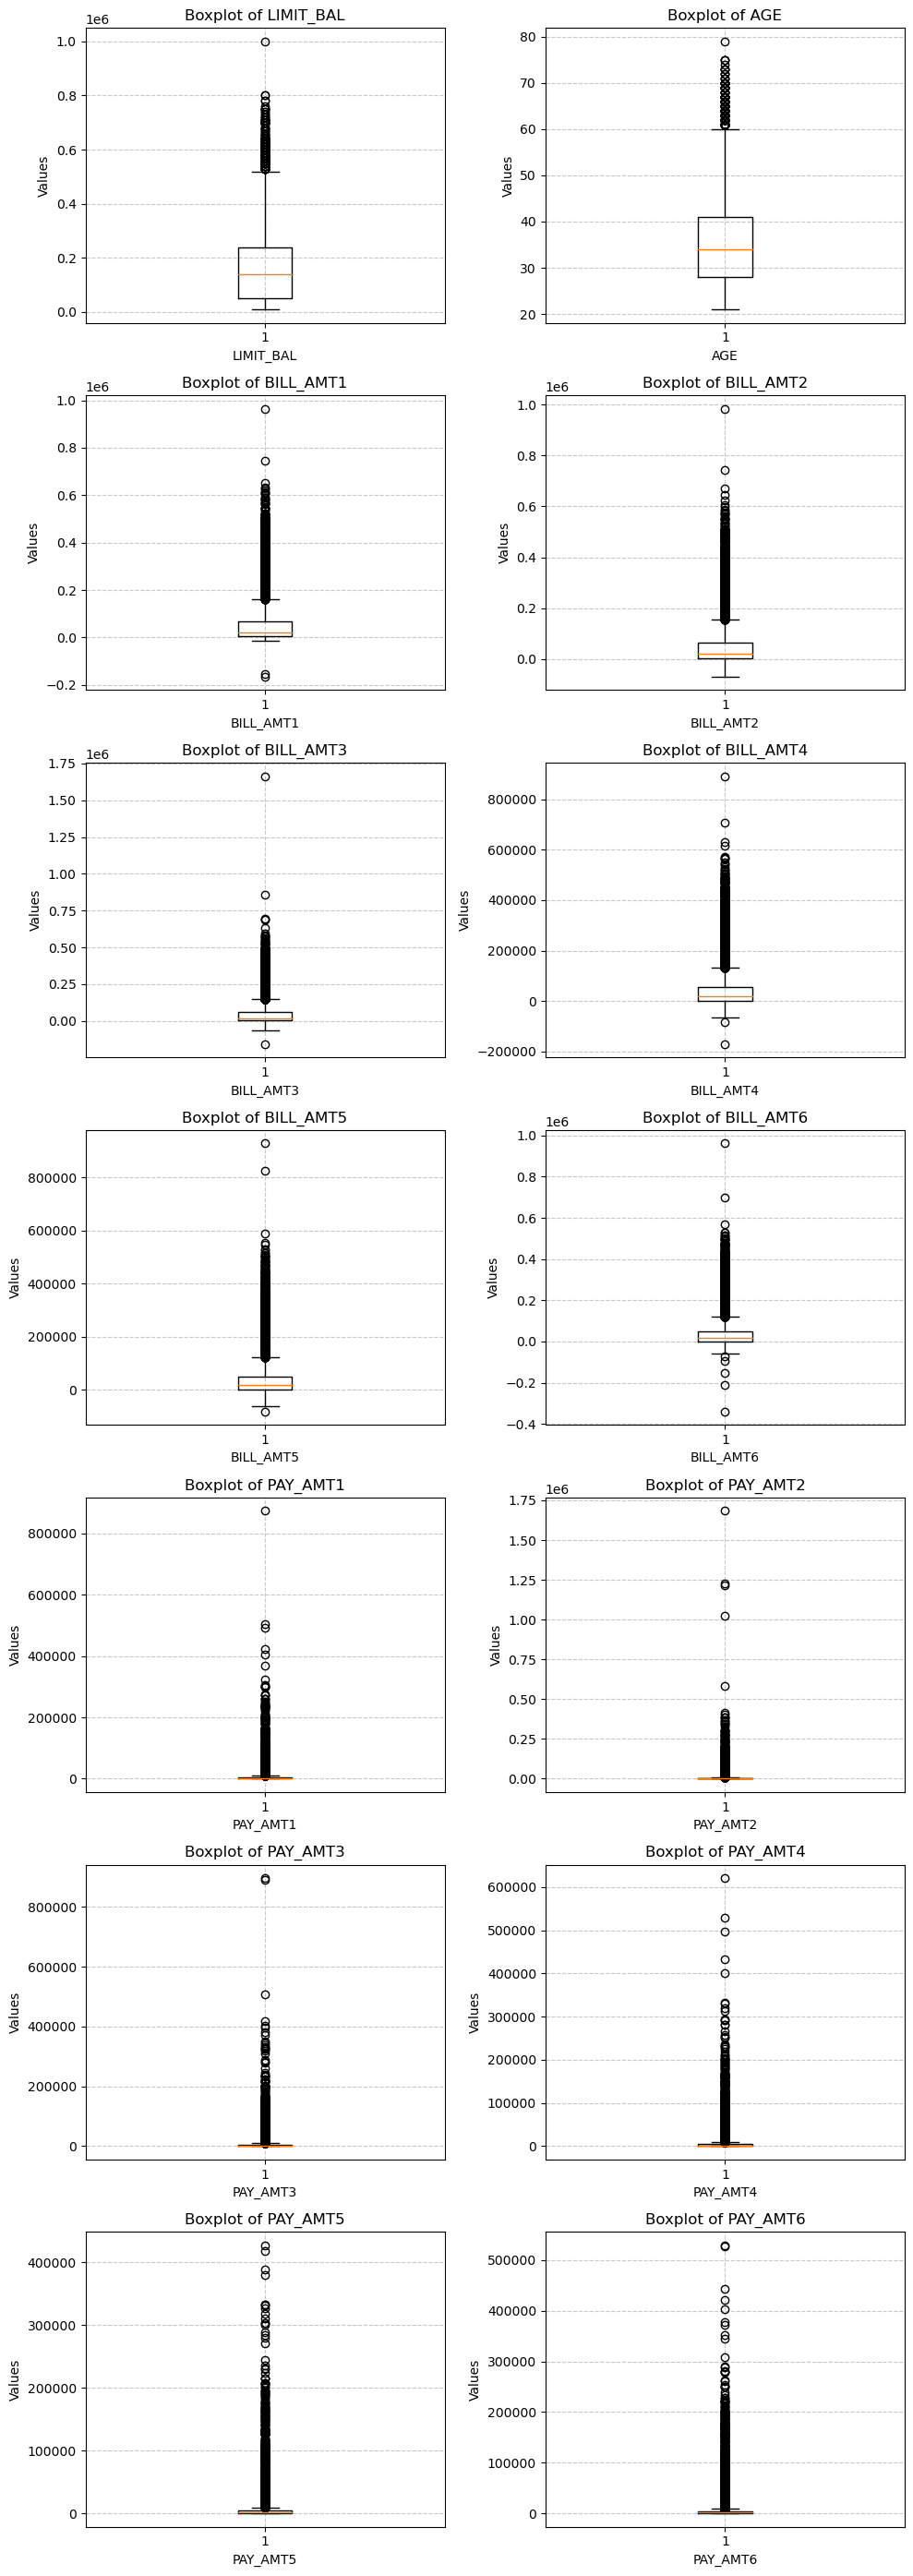

In [15]:
#plenty of outliers --> we will use RobustScaler() to scale the continuous features, which is robust to outliers
plot_boxplots(data[numerical_cols])

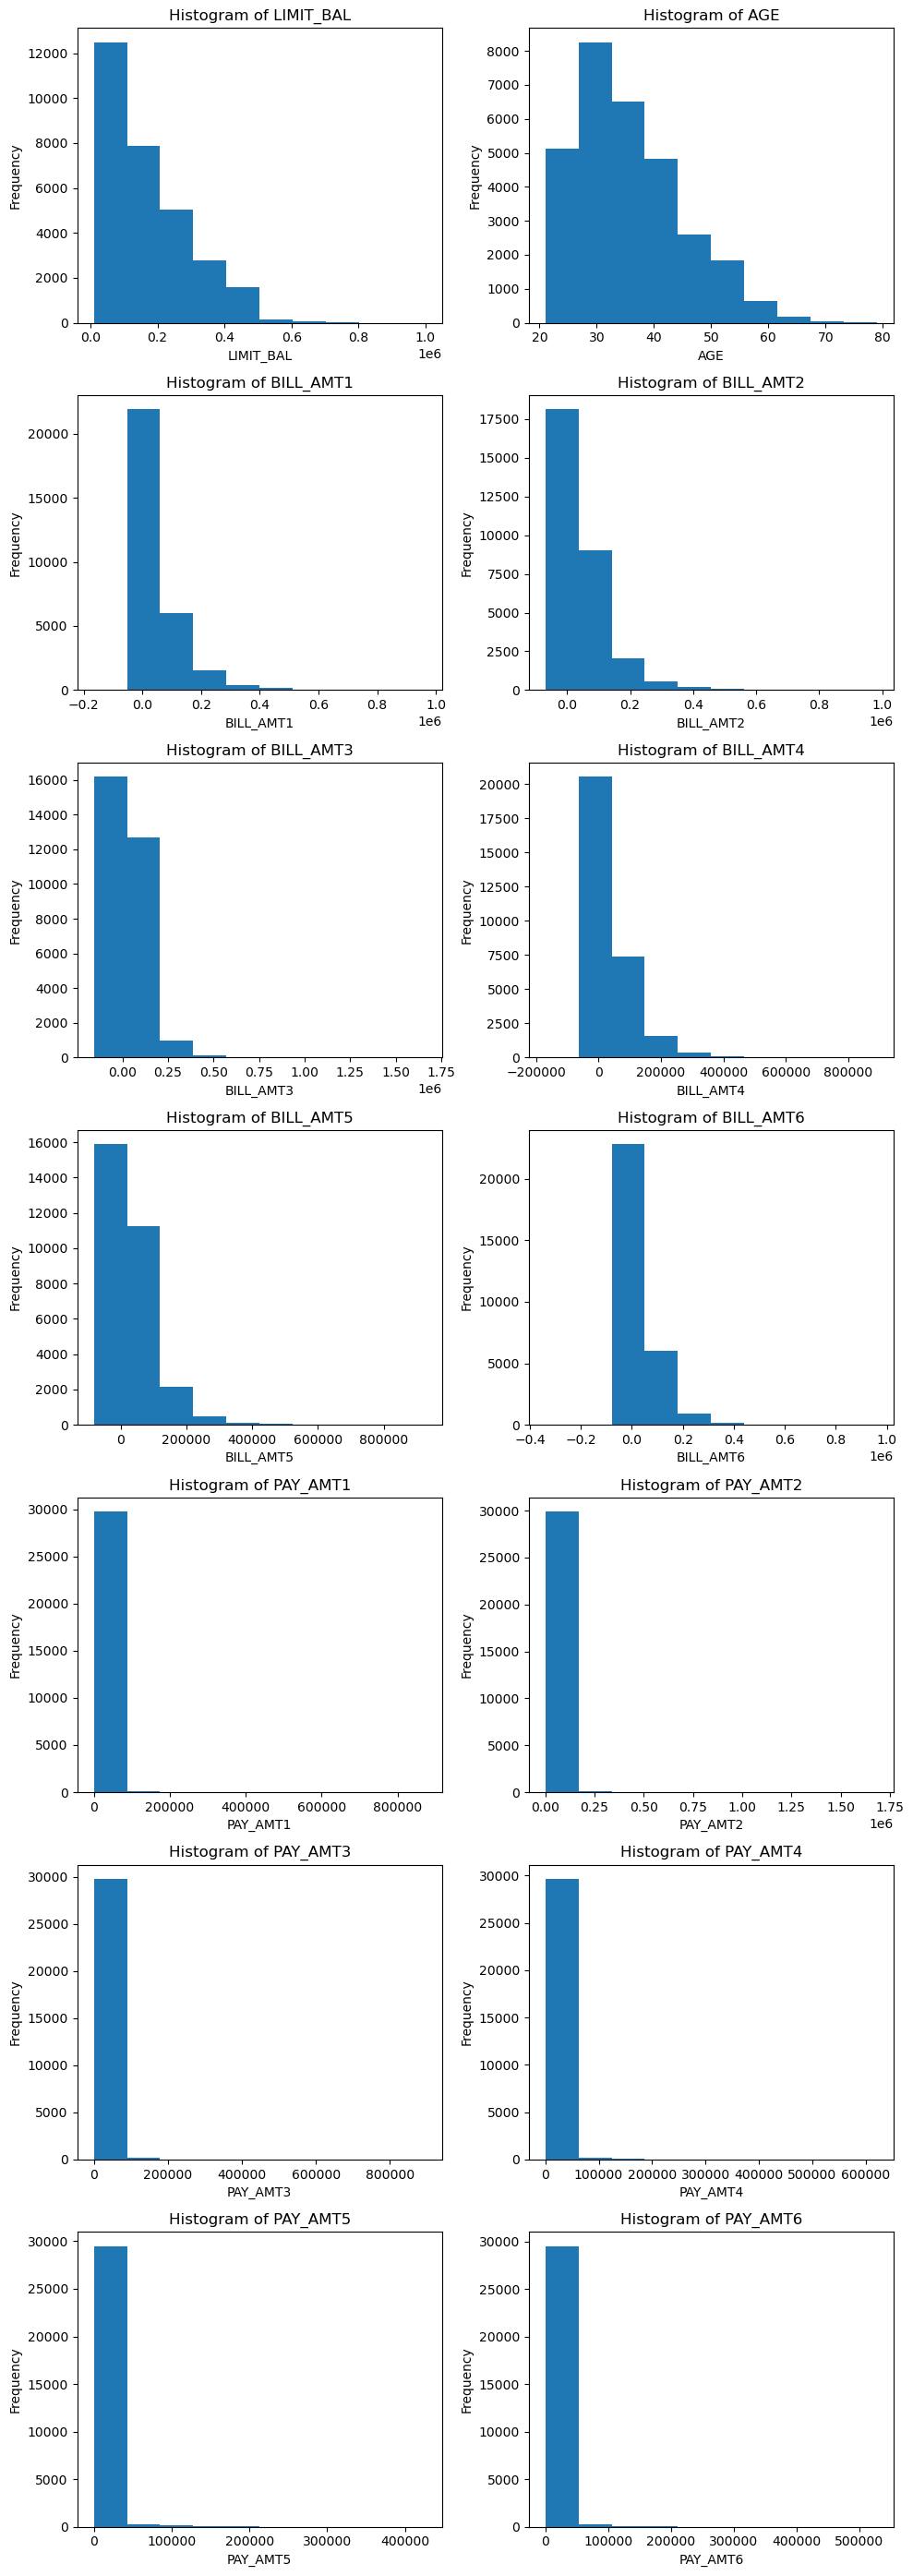

In [16]:
#most of the continuous features are highly right skewed, so we cannot use StandardScaler (no Gaussian distributions)
plot_histograms(data[numerical_cols])

## Chi2 test for PAY_1 - PAY_6 and target variable to check predictability

### The results show that the predictability is high, so I could also one hot encode those variables (cause they are important) but the dimensionality becomes pretty high, nearly 63 new columns. Accuracy goes from 0.8101 to 0.819, and the AUC from 0.72 to 0.76 but I kept the model simple and let those variables as they are.

In [17]:
def perform_chi2_test(data, categorical_vars, target_var):
    chi2_results = {}
    
    for var in categorical_vars:
        contingency_table = pd.crosstab(data[var], data[target_var])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results[var] = {'chi2': chi2, 'p_value': p_value}
    
    return chi2_results


In [18]:
perform_chi2_test(data,['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],'DEFAULT')

{'PAY_1': {'chi2': 5365.964977413581, 'p_value': 0.0},
 'PAY_2': {'chi2': 3474.4667904168564, 'p_value': 0.0},
 'PAY_3': {'chi2': 2622.4621276828025, 'p_value': 0.0},
 'PAY_4': {'chi2': 2341.469945438205, 'p_value': 0.0},
 'PAY_5': {'chi2': 2197.694900930992, 'p_value': 0.0},
 'PAY_6': {'chi2': 1886.835309001187, 'p_value': 0.0}}

## Train test split - OHE - Scaling of numerical features - VIF backwards feature selection

In [19]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [20]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_encoded = pd.get_dummies(X_train, columns = ['EDUCATION','MARRIAGE'], drop_first = True)
cols_train = X_train_encoded.columns.tolist()

In [21]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_encoded = pd.get_dummies(X_test,columns = ['EDUCATION','MARRIAGE'], drop_first = True)
X_test_encoded = X_test_encoded.reindex(columns = cols_train).fillna(0)   #if unknown columns assign 0

In [22]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_scaled_encoded = copy.deepcopy(X_train_encoded)
X_train_scaled_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the test data using the fitted scaler
X_test_scaled_encoded = copy.deepcopy(X_test_encoded)
X_test_scaled_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

In [23]:
#VIF backwards selection to prevent multicollinearity of features
#Variance Inflation Factor: This function checks the VIF of each feature, and if it's > 5 it removes this feature and recomputes the VIF.
#The columns that are kept are returned from the function
#The input df is modified as the columns with high VIF are removed 

def VIF(df):
    
    vif_df = pd.DataFrame()
    vif_df['variable'] = df.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print('VIF before selection:',vif_df)

    while True:
        if sum(vif_df['VIF'] > 5) > 0:
            array = vif_df[vif_df['VIF'] > 5]['VIF'].values
            if np.isin(array,math.inf).any():
                    col_max_vif = vif_df[vif_df['VIF']==math.inf]['variable'][:1]
            else:
                    col_max_vif = vif_df[vif_df['VIF']==max(array)]['variable']

            df.drop(col_max_vif.values[0],axis=1, inplace=True)
            vif_df = pd.DataFrame()
            vif_df['variable'] = df.columns 
            vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
            print('\nColumn removed:',col_max_vif.values[0])
            print('---------------------')
            print('VIF after selection:',vif_df)

        else:
            break
            
    keep_col = list(df.columns)

    return(keep_col)

In [24]:
#X_train_scaled_encoded colums before feature selection 
X_train_scaled_encoded.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

In [25]:
#Run the feature selection process and save the remaining features in the variable 'cols'
X_train_scaled_encoded_VIF = copy.deepcopy(X_train_scaled_encoded)
cols = VIF(X_train_scaled_encoded_VIF)

VIF before selection:        variable        VIF
0     LIMIT_BAL   1.646754
1           SEX   4.118050
2           AGE   1.336883
3         PAY_1   1.898274
4         PAY_2   3.225797
5         PAY_3   3.716629
6         PAY_4   4.396722
7         PAY_5   4.933584
8         PAY_6   3.417426
9     BILL_AMT1  16.148898
10    BILL_AMT2  31.919493
11    BILL_AMT3  28.877676
12    BILL_AMT4  23.666447
13    BILL_AMT5  27.467941
14    BILL_AMT6  16.881997
15     PAY_AMT1   1.809550
16     PAY_AMT2   2.323668
17     PAY_AMT3   1.906885
18     PAY_AMT4   1.692031
19     PAY_AMT5   1.741010
20     PAY_AMT6   1.230373
21  EDUCATION_2   2.256924
22  EDUCATION_3   1.576790
23  EDUCATION_4   1.049282
24   MARRIAGE_2   2.320215
25   MARRIAGE_3   1.037036

Column removed: BILL_AMT2
---------------------
VIF after selection:        variable        VIF
0     LIMIT_BAL   1.646573
1           SEX   4.117389
2           AGE   1.336770
3         PAY_1   1.898259
4         PAY_2   3.225761
5         PAY_3  

In [26]:
#X_train_scaled_encoded_VIF columns after feature selection
X_train_scaled_encoded_VIF.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

In [27]:
#Use only the columns dictated from the VIF on X_train_scaled_encoded_VIF --> X_test_final
X_test_final = X_test_scaled_encoded[cols]

In [28]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [29]:
X_train_SMOTE = copy.deepcopy(X_train_scaled_encoded_VIF)
y_train_SMOTE = copy.deepcopy(y_train)

In [30]:
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

## Logistic Regression Model - Evaluation Metrics - ROC CURVE

### With VIF 



In [31]:
# Create a LogisticRegression object, max_iter=300 to remove the warning "ConvergenceWarning: lbfgs failed to converge (status=1)"
logreg = LogisticRegression(max_iter=300)

# Fit the model on the training data
logreg.fit(X_train_scaled_encoded_VIF, y_train)

# Predict on the test data
y_pred = logreg.predict(X_test_final)

In [32]:
#Even though the accuracy is good, the other metrics are not that good due to the imbalance of the dataset 
print('Accuracy:', accuracy_score(y_test,y_pred))
print('Precision:', precision_score(y_test,y_pred))
print('Recall:', recall_score(y_test,y_pred))
print('F1 score:', f1_score(y_test,y_pred))

Accuracy: 0.8087777777777778
Precision: 0.6979472140762464
Recall: 0.23907584128578604
F1 score: 0.35615413393191175


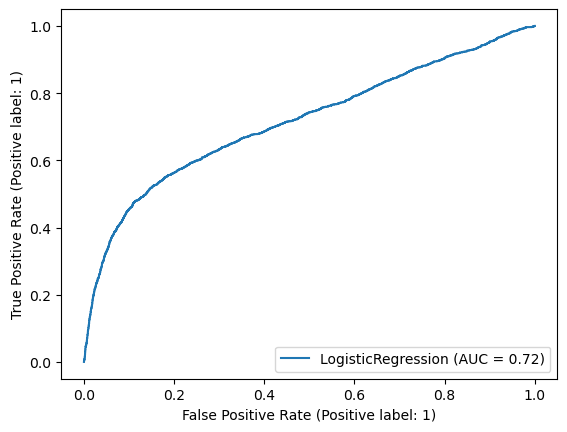

In [33]:
#ROC Curve plot - VIF
RocCurveDisplay.from_estimator(logreg, X_test_final, y_test)

### Without VIF

In [34]:
# Create a LogisticRegression object, max_iter=300 to remove the warning "ConvergenceWarning: lbfgs failed to converge (status=1)"
logreg2 = LogisticRegression(max_iter=300)

# Fit the model on the training data
logreg2.fit(X_train_scaled_encoded, y_train)

# Predict on the test data
y_pred2 = logreg2.predict(X_test_scaled_encoded)

In [35]:
#Lower scores compared to the VIF solution 
print('Accuracy:', accuracy_score(y_test,y_pred2))
print('Precision:', precision_score(y_test,y_pred2))
print('Recall:', recall_score(y_test,y_pred2))
print('F1 score:', f1_score(y_test,y_pred2))

Accuracy: 0.809
Precision: 0.6994134897360704
Recall: 0.2395781014565545
F1 score: 0.3569023569023569


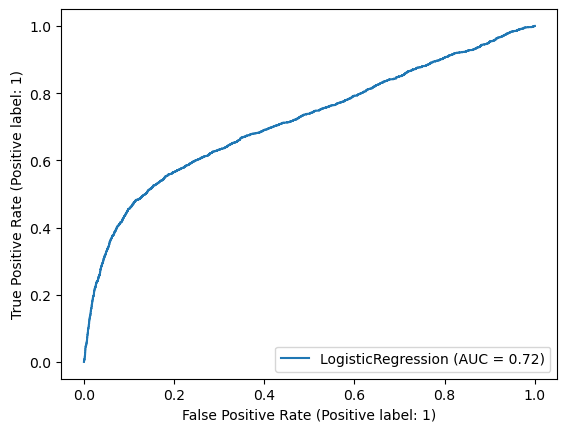

In [36]:
#ROC Curve plot - No VIF
RocCurveDisplay.from_estimator(logreg2, X_test_scaled_encoded, y_test)

### With SMOTE

In [37]:
# Create a LogisticRegression object, max_iter=300 to remove the warning "ConvergenceWarning: lbfgs failed to converge (status=1)"
logreg3 = LogisticRegression(max_iter=300)

# Fit the model on the training data
logreg3.fit(X_train_SMOTE, y_train_SMOTE)

# Predict on the test data
y_pred3 = logreg3.predict(X_test_final)

In [38]:
#Lower scores compared to the VIF solution 
print('Accuracy:', accuracy_score(y_test,y_pred3))
print('Precision:', precision_score(y_test,y_pred3))
print('Recall:', recall_score(y_test,y_pred3))
print('F1 score:', f1_score(y_test,y_pred3))

Accuracy: 0.8075555555555556
Precision: 0.5967139656460044
Recall: 0.401305876443998
F1 score: 0.4798798798798799


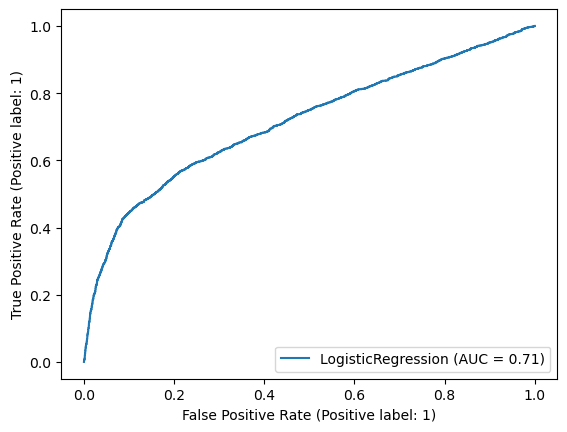

In [39]:
#ROC Curve plot - No VIF
RocCurveDisplay.from_estimator(logreg3, X_test_final, y_test)